# MIE1613 Project: Developing the simplified operational-FIG emissions and embodied emissions for Toronto

In [1]:
# Import Libraries
# Data
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import random

import re
from copy import deepcopy
#from tqdm import tqdm
import tqdm.notebook as tq

#Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(font='Helvetica') # Futura? Calibri Light? 
sns.set_style("white")
sns.set_theme(style='ticks')
sns.set_context('talk')

c:\Users\Keagan Rankin\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Keagan Rankin\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


## LENZ-TEMOA Operational Emissions
Determining the cost-optimal operational emissions per building unit of each residential type using LENZ-TEMOA outputs

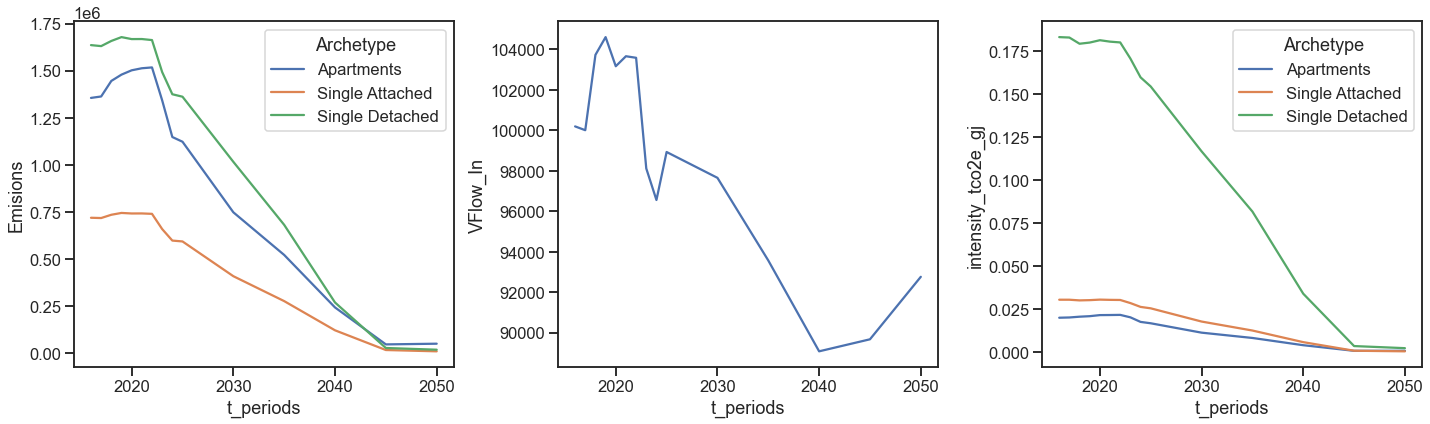

In [2]:
# import relevant excel files
lenz_emission_df = pd.read_csv("data/lenz/Emissions_Building_archetype.csv", header=1)
lenz_energy_df = pd.read_csv("data/lenz/Energy_Building_Technology.csv", header=1)

# group emissions from resdential
lenz_emission_df_t = lenz_emission_df[(lenz_emission_df['emissions_comm'] == 'CO2e') &
                                      (lenz_emission_df['Sub'] == 'Residential')
                                      ].groupby(['t_periods','Archetype']).agg({'emissions_comm':'first',
                                                                                'Sub':'first',
                                                                                'Emisions':'sum'}
                                                                                ).reset_index()

# Find energy use by residential
lenz_energy_df_rest = lenz_energy_df[lenz_energy_df['Sub'] == 'Residential'].groupby('t_periods').agg({'VFlow_In':'sum'})


# Calculate avg emission intensity of residential sector over time: metric tons of CO2e/TJ
arch = lenz_emission_df_t['Archetype'].unique()
intensity_l = []

# Need to divide by share of housing unit types in Toronto.
# https://www12.statcan.gc.ca/census-recensement/2021/dp-pd/prof/details/page.cfm?Lang=E&GENDERlist=1&STATISTIClist=1&HEADERlist=0&DGUIDlist=2021A00053520005&SearchText=toronto
types = [(542625+162245+47810+62915*0.5)/1160890, (270490+2770)/1160890, (71955+62915*0.5)/1160890]
type_fracs = dict(zip(arch,types))

# Calculate the ghg intensity per gj for each housing type
# Assumes housing share built in future is proportional to current.
for a in arch:
   intensity_l.append(lenz_emission_df_t[lenz_emission_df_t['Archetype'] == a]['Emisions']
                      .values/(lenz_energy_df_rest['VFlow_In'].values*type_fracs[a]*1000)) # replace type_fracs for share of housing


intensity_df = lenz_emission_df_t.copy()
for i, a in enumerate(arch):
    intensity_df.loc[intensity_df['Archetype'] == a,'Emisions'] = intensity_l[i]

intensity_df= intensity_df.rename(columns={'Emisions':'intensity_tco2e_gj'})


# Calculate emissions from residential
fig, ax = plt.subplots(1,3, figsize=(20,6))
sns.lineplot(ax=ax[0], data=lenz_emission_df_t, x='t_periods', y='Emisions', hue='Archetype')
sns.lineplot(ax=ax[1], data=lenz_energy_df_rest, y='VFlow_In', x=lenz_energy_df_rest.index)
sns.lineplot(ax=ax[2], data=intensity_df, x='t_periods', y='intensity_tco2e_gj', hue='Archetype')

plt.tight_layout()

In [3]:
type_fracs

{'Apartments': 0.6754623607749227,
 'Single Attached': 0.2353883658227739,
 'Single Detached': 0.08908036075769453}

I use NRC data to get the historical energy use per floor area and per unit over the last quarter century for the three housing types. https://oee.nrcan.gc.ca/corporate/statistics/neud/dpa/menus/trends/comprehensive/trends_res_on.cfm <br>
floor area is decreasing over steadily time. We can fit a simple linear model to each assuming reductions to 2030

<Axes: >

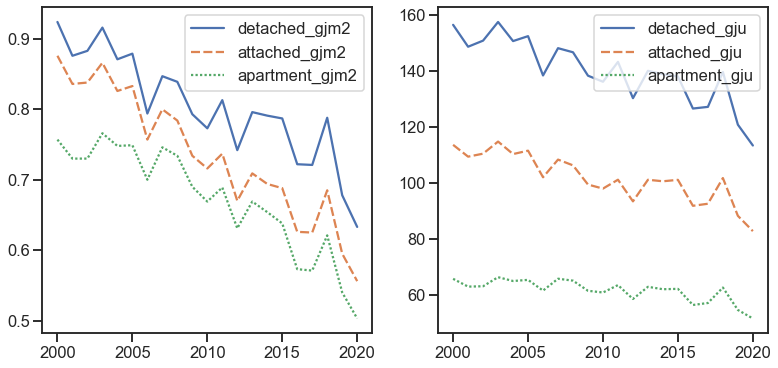

In [4]:
NRC_m2 = {'Single Detached':0.63}
sd = pd.read_excel('data/res_on_e_34.xls', header=10)#.loc[20].values[2:]
sa = pd.read_excel('data/res_on_e_36.xls', header=10)#.loc[20].values[2:]
ap = pd.read_excel('data/res_on_e_38.xls', header=10)#.loc[20].values[1:]
ap.loc[20].values[1:]
df_ldr = [sd.loc[20].values[2:], sd.loc[21].values[2:], sa.loc[20].values[2:], sa.loc[21].values[2:], ap.loc[20].values[2:], ap.loc[21].values[2:]]
cols = ['detached_gjm2','detached_gju','attached_gjm2','attached_gju','apartment_gjm2','apartment_gju']

nrc_df = pd.DataFrame(data=np.array(df_ldr).T, index=np.arange(2000,2021), columns=cols)

fig, ax = plt.subplots(1,2, figsize=(13,6))
sns.lineplot(nrc_df[['detached_gjm2','attached_gjm2','apartment_gjm2']], ax=ax[0])
sns.lineplot(nrc_df[['detached_gju','attached_gju','apartment_gju']], ax=ax[1])

<Axes: >

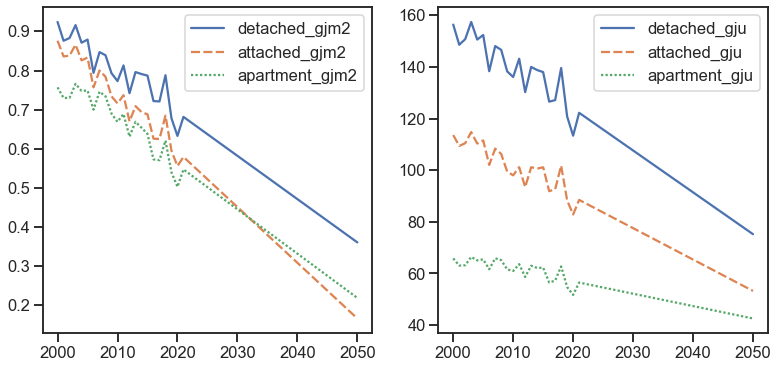

In [5]:
# loop over each of the NRC time series and fit a simple linear model to them with an intercept.
import statsmodels.api as sm

mdls = {'params':[], 'r2':[]}
for c in nrc_df.columns.values:
    y = nrc_df[c].values
    x = np.arange(2000,2021)

    x = sm.add_constant(x)
    mld = sm.OLS(y,x).fit()
    mdls['params'].append(mld.params)
    mdls['r2'].append(mld.rsquared)

# get linear model values to 2050, store params and c-o-d value
fut_x = np.arange(2021,2051)
futs = []
for m in mdls['params']:
    futs.append(m[0] + fut_x*m[1])

futur_model_proj = pd.DataFrame(np.array(futs).T, columns=nrc_df.columns, index=fut_x)
nrc_future_df = pd.concat([nrc_df,futur_model_proj])

fig, ax = plt.subplots(1,2, figsize=(13,6))
sns.lineplot(nrc_future_df[['detached_gjm2','attached_gjm2','apartment_gjm2']], ax=ax[0])
sns.lineplot(nrc_future_df[['detached_gju','attached_gju','apartment_gju']], ax=ax[1])

MAY WANT TO CONSIDER UNIFORM SCENARIO WHERE THERE IS NO IMPROVEMENT IN GJ PER UNIT VS THE PROJECTED LINEAR IMPROVEMENT

<Axes: >

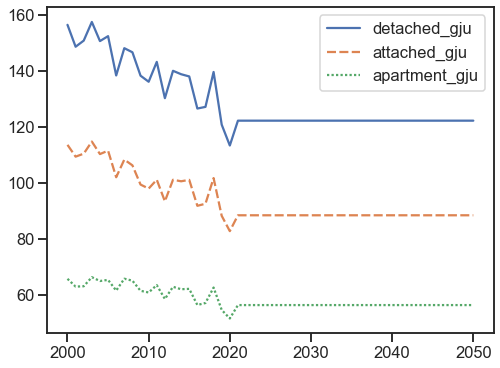

In [6]:
# create a range with no increase in efficiency of energy per unit
no_efficiency = nrc_future_df[['detached_gju','attached_gju','apartment_gju']].copy()
for col in no_efficiency.columns:
    no_efficiency.loc[2021:,col] = no_efficiency.loc[2021,col]

fig, ax = plt.subplots(figsize=(8,6))
sns.lineplot(no_efficiency[['detached_gju','attached_gju','apartment_gju']], ax=ax)

Now we can calc energy emissions per m2 or per unit

In [7]:
# split intensity df by archetype so we can interpolate the missing year values
intensity_df_sd = intensity_df.loc[intensity_df['Archetype'] == 'Single Detached']
intensity_df_sa = intensity_df.loc[intensity_df['Archetype'] == 'Single Attached']
intensity_df_ap = intensity_df.loc[intensity_df['Archetype'] == 'Apartments']
i_arch = [intensity_df_sd, intensity_df_sa, intensity_df_ap]

# for each archetype, join onto the NRC frame (leads to NA values in years not in 5 year increments)
# we then linearly interpolate the missing values and multiple tco2e/gj * gj/m2 or gj/unit = tco2e/m2 or tco2/unit
energy_emissions = []
for i in i_arch:
   jn = nrc_future_df.loc[2020:].join(i.set_index('t_periods')[['intensity_tco2e_gj','Archetype']])
   energy_emissions.append(jn)

# extend with lienear interpolation and multiple
arch_n = ['Single Detached', 'Single Attached', 'Apartments']
slicer = [[0,2],[2,4],[4,6]]
emission_intensity = []
for i in range(3):
   emission_intensity.append(energy_emissions[i].iloc[:,slicer[i][0]:slicer[i][1]].multiply(energy_emissions[i].iloc[:,6].interpolate().values, axis=0))
   #emission_intensity[i]['Archetype'] = arch_n[i]

emission_intensity = pd.concat(emission_intensity, axis=1)

# -- #
#energy_emissions[2].iloc[:,:6].multiply(energy_emissions[2].iloc[:,6].interpolate().values, axis=0)
#energy_emissions[2]['intensity_tco2e_gj'].interpolate().values
#emission_intensity[0]

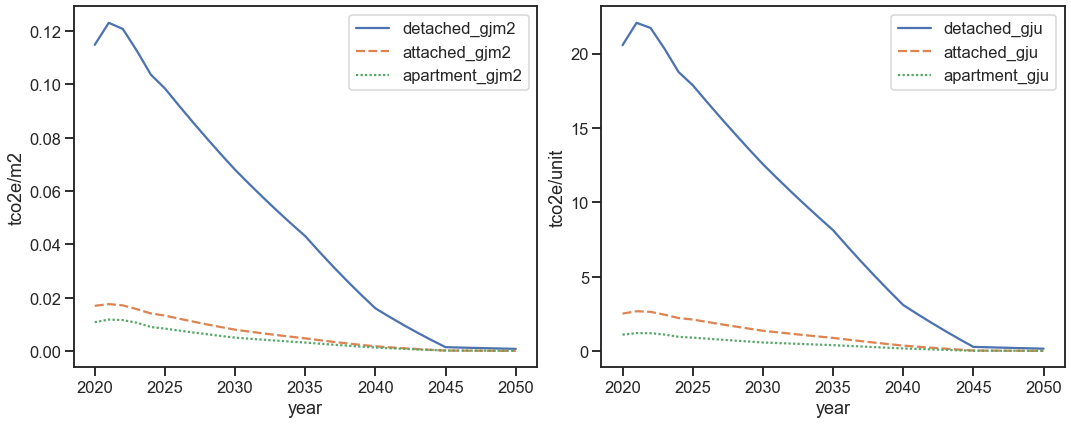

In [8]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.lineplot(emission_intensity[['detached_gjm2','attached_gjm2', 'apartment_gjm2']].loc[2020:],
             ax=ax[0])
sns.lineplot(emission_intensity[['detached_gju','attached_gju', 'apartment_gju']].loc[2020:],
             ax=ax[1])

ax[0].set_ylabel('tco2e/m2')
ax[1].set_ylabel('tco2e/unit')
ax[0].set_xlabel('year')
ax[1].set_xlabel('year')

plt.tight_layout()

plot no efficiency increase vs linear increase

In [11]:
emission_intensity

,detached_gjm2,detached_gju,attached_gjm2,attached_gju,apartment_gjm2,apartment_gju
2020,0.114862,20.569917,0.016992,2.531875,0.010841,1.114637
2021,0.123107,22.073891,0.017624,2.692314,0.011825,1.220475
2022,0.120802,21.725766,0.017153,2.649512,0.011623,1.214561
2023,0.112631,20.318918,0.015728,2.457371,0.01063,1.125058
2024,0.103654,18.759234,0.014127,2.233752,0.009036,0.968979
2025,0.098494,17.884042,0.01332,2.132497,0.008437,0.917045
2026,0.092063,16.773269,0.012175,1.974766,0.007711,0.849954
2027,0.0858,15.686929,0.011075,1.820773,0.00701,0.78391
2028,0.079702,14.62502,0.010018,1.670518,0.006334,0.718912
2029,0.073772,13.587544,0.009005,1.524001,0.005682,0.654961


Save to file

In [332]:
# with linear increase in efficiency
#emission_intensity[['detached_gju','attached_gju', 'apartment_gju']].to_csv('CALCULATED_operational_intensity_2020_2050.csv')

# with no increase in efficiency

## Embodied Emissions
I import and re-organize the embodied emission data for residential buildings from our database. The simplify input generation is similar to the plot directly above, except there is uncertainty from the volume (based on house type) and time-dependent emission factor. One outcome could be plotting a distribution for each housign type in a base year.

### Import the data
import housing data from dataset. I am using some FIG functions that auto clean and import the data

In [12]:
from packages.fig_package.fig_sample.house_clean_sample import *
#building_summary_data = House_data_importer.ontology_import_and_clean(House_data_importer.o_path)

c:\Users\Keagan Rankin\anaconda3\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [13]:
House_data_importer = HouseClean(master='C:/Users/Keagan Rankin/')
# there are three emission settings: minimum, maximum, most likely.
# these are extremely hard to the simulate stochastically as it would involved fitting up to 35000 distributions
# so intead we analyze this effect using sensitivity
ee_min_df = House_data_importer.import_process_house_data('GHG Quantity 1 Min')
ee_mostlikely_df = House_data_importer.import_process_house_data('GHG Quantity 1 Most Likely')
ee_max_df = House_data_importer.import_process_house_data('GHG Quantity 1 Max')

[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data


In [14]:
ee_mostlikely_df['mm_split_labels'].unique()

array(['Single Family', 'Semi-Detached', 'Laneway', 'Rowhouses',
       'Mid High Rise', 'Low-Rise Apartments', 'Multiplexes'],
      dtype=object)

Visualize

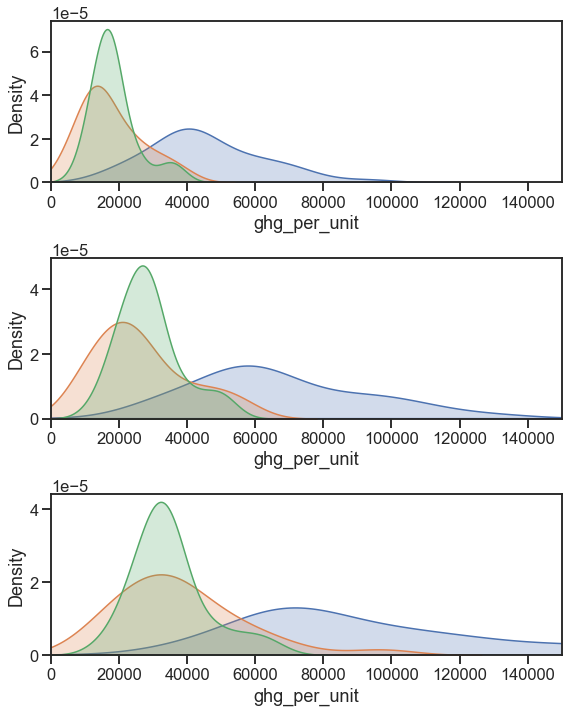

In [15]:
fig, ax = plt.subplots(3,1,figsize=(8,10))

lmh = ['Single Family','Missing Middle','Mid High Rise']
ee_l = [ee_min_df.loc[ee_min_df['mm_split_labels']!='Laneway'], 
        ee_mostlikely_df.loc[ee_min_df['mm_split_labels']!='Laneway'], 
        ee_max_df.loc[ee_min_df['mm_split_labels']!='Laneway']]

for j, ee_j in enumerate(ee_l):
    for i in lmh:
        crit = ee_j['labels_general'] == i
        sns.kdeplot(ax=ax[j], data=ee_j.loc[crit], x='ghg_per_unit', fill=True)
        ax[j].set_xlim([-100,150000])

plt.tight_layout()

<Axes: xlabel='ghg_per_unit', ylabel='Density'>

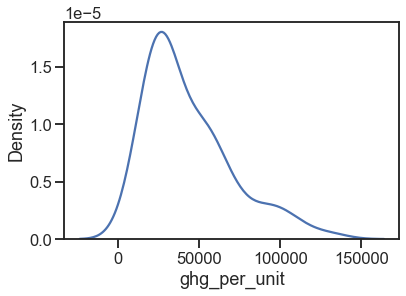

In [281]:
sns.kdeplot(ee_mostlikely_df['ghg_per_unit'])

### The emissions reduce each year
I can run .import_process_house_data_matreduction() for each year for max min most likely and save all of the csv files. Then I there wont be a long import every time.

In [276]:
#foob = House_data_importer.import_process_house_data_matreduction('GHG Quantity 1 Most Likely', year=2040)

ghg_quant = 'GHG Quantity 1 Max'
for i in range(2023,2051):
    emb_red_i = House_data_importer.import_process_house_data_matreduction(ghg_quant, year=i)
    emb_red_i.to_csv('embodied_'+str(i)+'_max.csv')
    print('saved embodied_'+str(i)+'_max.csv')

[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2023_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2024_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2025_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2026_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2027_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2028_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2029_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2030_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2031_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2032_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2033_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2034_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2035_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2036_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2037_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2038_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2039_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2040_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2041_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2042_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2043_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2044_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2045_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2046_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2047_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2048_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2049_max.csv
[Info] importing ontology...


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


[Info] ontology import complete.
(15676, 18)
(15641, 18)
2/3: Labelling house data.
2.5/3: Reducing emission factors.
3/3: Interpolate total ghg for midhigh rise.
Complete, Returning grouped Housing Data
saved embodied_2050_max.csv


### Fitting the embodied emissions distributions
Previous FIG work fit distributions naively at runtime and minimized KS statistic for idividual housing forms. Here (since we are not using neighbourhoods and therefore do not need the housing forms), we can fit a distribution to the general housing type L, M, or H as described in proposal (either through MLE or bootstrapping) and use these to carry out input uncertainty analysis

In [16]:
# get desired housing types, I will only fit to non-laneways and most likely (others are just scaled version of this)
ee_fittr = ee_mostlikely_df.loc[ee_min_df['mm_split_labels']!='Laneway']
ee_fittr

,GHG Quantity 1 Most Likely,Units,mm_split_labels,labels_general,ghg_per_unit
Building Key,,,,,
1,9.336131e+04,1.0,Single Family,Single Family,93361.310116
2,3.426267e+04,1.0,Single Family,Single Family,34262.674114
3,5.895746e+04,1.0,Single Family,Single Family,58957.461491
4,3.444122e+04,1.0,Single Family,Single Family,34441.217406
7,5.195198e+04,1.0,Single Family,Single Family,51951.977079
...,...,...,...,...,...
86,6.242340e+06,210.0,Mid High Rise,Mid High Rise,29725.427029
87,1.493289e+07,545.0,Mid High Rise,Mid High Rise,27399.796867
90,7.456163e+06,363.0,Mid High Rise,Mid High Rise,20540.393865


Fit a few distributions and compare

In [18]:
# store distributions of interest
distributions = (stats.norm, stats.triang, stats.lognorm, stats.beta)
dis_names = ('norm','triang', stats.lognorm.name,'beta')
lmh = ['Single Family','Missing Middle','Mid High Rise']
house_type = 1
d_col = 'ghg_per_unit'

# get data
data = ee_fittr.loc[ee_fittr['labels_general']==lmh[house_type]][d_col]

# fit
parameters = [d.fit(data) for d in distributions]

# Calculate KS statistic
ks_res = [stats.kstest(rvs=data, cdf=dis_names[i], args=parameters[i],
                    ) for i in (range(len(dis_names)))]

# Return max index
#ks_p = [k[1] for k in ks_res]
#i_max = max(range(len(ks_p)), key=ks_p.__getitem__) 
parameters
ks_res

[KstestResult(statistic=0.1412575791306292, pvalue=0.6044646386078716, statistic_location=24936.009367448976, statistic_sign=1),
 KstestResult(statistic=0.10965962417017838, pvalue=0.8667915948865962, statistic_location=30023.679340183833, statistic_sign=1),
 KstestResult(statistic=0.08183108631608237, pvalue=0.9867603710184363, statistic_location=10690.149265251806, statistic_sign=1),
 KstestResult(statistic=0.17691299910313107, pvalue=0.3271948283909327, statistic_location=30023.679340183833, statistic_sign=1)]

Plot qq - create a function for it

In [19]:
def emperical_quantile(data):
    """Pass data return empirical quantiles"""
    sorted_data = np.sort(data)
    prob = (np.arange(1, len(data) + 1) -0.5)/ len(data) 
    empirical_quantiles = sorted_data

    return empirical_quantiles, prob

def plot_quantile(axs, distfunc, distparams, distname, data):
    """
    Plot the qq plot of the given data
    ax = matplotlib axis
    distfunc = scipy.stats distribution to compare agaisnt
    distparams = MLE fit parameters
    distname = name of dist
    data = data to check. Calcs empirical quantiles
    """
    # Calc empirical quantiles
    empiricals = emperical_quantile(data)

    # Theoretical quantiles
    theoretical_quantiles = distfunc.ppf(empiricals[1], *distparams)

    # Plot
    axs.plot(theoretical_quantiles, empiricals[0], 'o', markersize=7, alpha=0.7, color='k')
    axs.plot(theoretical_quantiles, theoretical_quantiles, 'r--')
    axs.set_title(f'Q-Q Plot: {distname}')
    axs.set_xlabel('Theo Q')
    axs.set_ylabel('Emp Q')

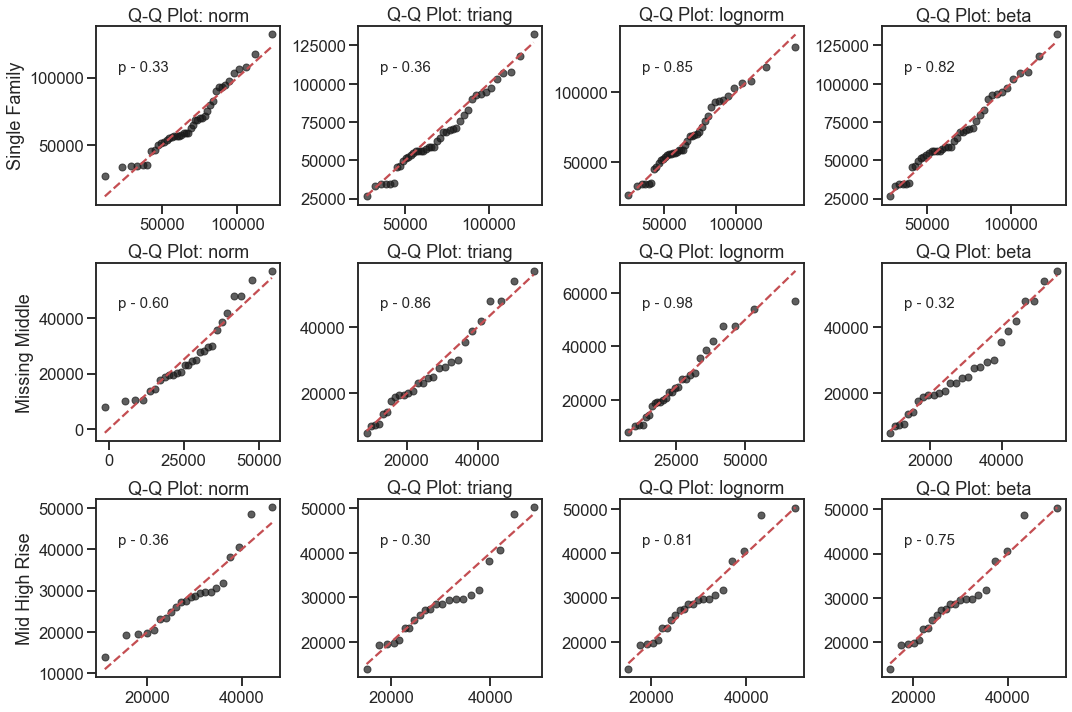

In [23]:
fig, ax = plt.subplots(3,4, figsize=(15,10))
distributions = (stats.norm, stats.triang, stats.lognorm, stats.beta)
dis_names = [d.name for d in distributions]

for j in range(3):
    house_type = j
    # get data
    data = ee_fittr.loc[ee_fittr['labels_general']==lmh[house_type]][d_col]
    # fit
    parameters = [d.fit(data) for d in distributions]
    # Calculate KS statistic
    ks_res = [stats.kstest(rvs=data, cdf=dis_names[i], args=parameters[i],) for i in (range(len(dis_names)))]
    #ax[j,0].text(0.12,0.65, s=lmh[house_type], size=15, transform=ax[j,0].transAxes)
    
    for i in range(4):
        plot_quantile(ax[j,i], distributions[i], parameters[i], distributions[i].name, data) #dis_names[i]
        ax[j,i].text(0.12,0.75, s='p - '+ks_res[i][1].astype(str)[:4], size=15, transform=ax[j,i].transAxes)
        ax[j,i].set_xlabel('')
        ax[j,i].set_ylabel('')
    
    ax[j,0].set_ylabel(lmh[house_type])
    
    
plt.tight_layout()

### Results:
- The single family and the mid/high rise buildings seem to fit a beta distribution and the log normal quite well. This fits some of the literature suggesting the use of a PERT/general risk distribution (modified bounded beta) for EPDs in embodied emissions. Mid/high fits an exponential norm well as well.
- Missing middle fits the tested distributions less well. Could do matching to beta/expo and draw from that.

Show example draws and the three fitted distributions together

<Axes: ylabel='Density'>

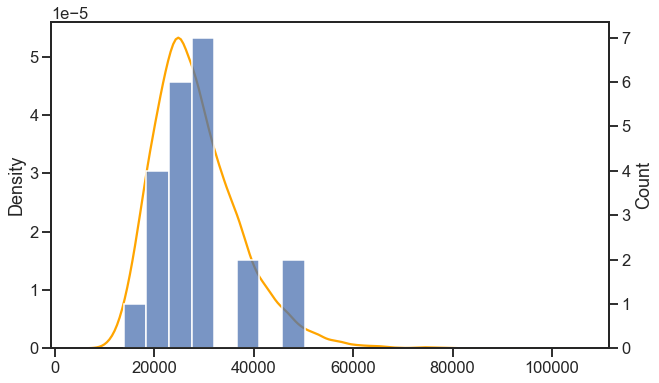

In [24]:
fig, ax = plt.subplots(figsize=(10,6))

data=ee_fittr.loc[ee_fittr['labels_general']==lmh[2]][d_col]
# data
# fit
parameters = [d.fit(data) for d in distributions]
realizations = distributions[2].rvs(*parameters[2], size=10000)
sns.histplot(data, ax=ax.twinx())
sns.kdeplot(realizations, ax=ax, color='orange')
#sns.kdeplot(realizations, ax=ax)
#sns.kdeplot(data, ax=ax)

c:\Users\Keagan Rankin\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


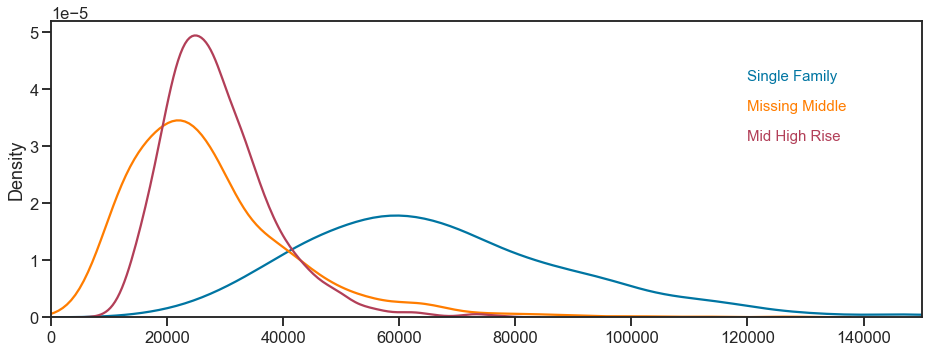

In [25]:
np.random.seed(1613)
fig, ax = plt.subplots(figsize=(13,5))
clrs = ['#0075A2', '#FF7D00', '#B23F58']
for i in [0,1,2]:
    data=ee_fittr.loc[ee_fittr['labels_general']==lmh[i]][d_col]
    parameters = [d.fit(data) for d in distributions]
    realizations = distributions[2].rvs(*parameters[2], size=1000)

    sns.kdeplot(realizations, ax=ax, color=clrs[i])
    ax.text(0.8,0.8-(i/10), s=lmh[i], size=15, transform=ax.transAxes, color=clrs[i])
    ax.set_xlim([0,150000])

plt.tight_layout()

# --------------------------------------
extra work
Saving emissions in just 3 csvs

In [ ]:
factor_range='max'
foo_emb = []
for year in range(2023,2051):
    print(year)
    strr = 'data/embodied/embodied_'+str(year)+'_'+factor_range+'.csv'
    foo_i = pd.read_csv(strr, index_col=0)
    foo_i['year'] = year
    foo_emb.append(foo_i)

In [ ]:
pd.concat(foo_emb).to_csv('embodied_max.csv')